In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch


In [2]:
d_sorts = ["CD-GraB", "D-RR"]


In [3]:
def exp_maker(n, sorter, seed):
    return f"{sorter}-node-{n}-lr-5.0-B-16-seed-{seed}"


In [4]:
results = {s: [] for s in d_sorts}
times = {s: [] for s in d_sorts}

for s in d_sorts:
    for seed in range(5):
        exp_details = exp_maker(4, s, seed)
        exp_folder = f"..{os.sep}..{os.sep}results{os.sep}lstm-wiki2{os.sep}{exp_details}"
        r = torch.load(f"{exp_folder}{os.sep}results.pt", map_location='cpu')
        results[s].append(r)
        for rank in range(4):
            time_folder = f"{exp_folder}{os.sep}time{os.sep}"
            times[s].append(torch.load(
                f"{time_folder}time-{rank}.pt", map_location='cpu'))


In [5]:
def down_sampling(len_sampling, data):
    start = 0
    end = len_sampling
    len_data = len(data)
    ret = []
    while end <= len_data:
        data_chunk = data[start:end]
        start += len_sampling
        end += len_sampling
        ret.append(torch.mean(torch.as_tensor(data_chunk)))
    return torch.as_tensor(ret)


In [8]:
def plot_res(ax, s, label, train_test, loss_ppl):
    res = []
    for arr in results[s]:
        res.append(torch.tensor(arr[train_test][loss_ppl]))
    end_pos = len(torch.tensor(results[s][0][train_test][loss_ppl])) + 1
    res = torch.vstack(res).numpy()
    mean = res.mean(axis=0)
    std = res.std(axis=0)
    ax.plot(np.arange(1, end_pos), mean, label=label, markersize=5)
    ax.fill_between(
        np.arange(1, end_pos), (mean - std), (mean + std), alpha=0.1)


/tmp/ipykernel_1104961/1767899010.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


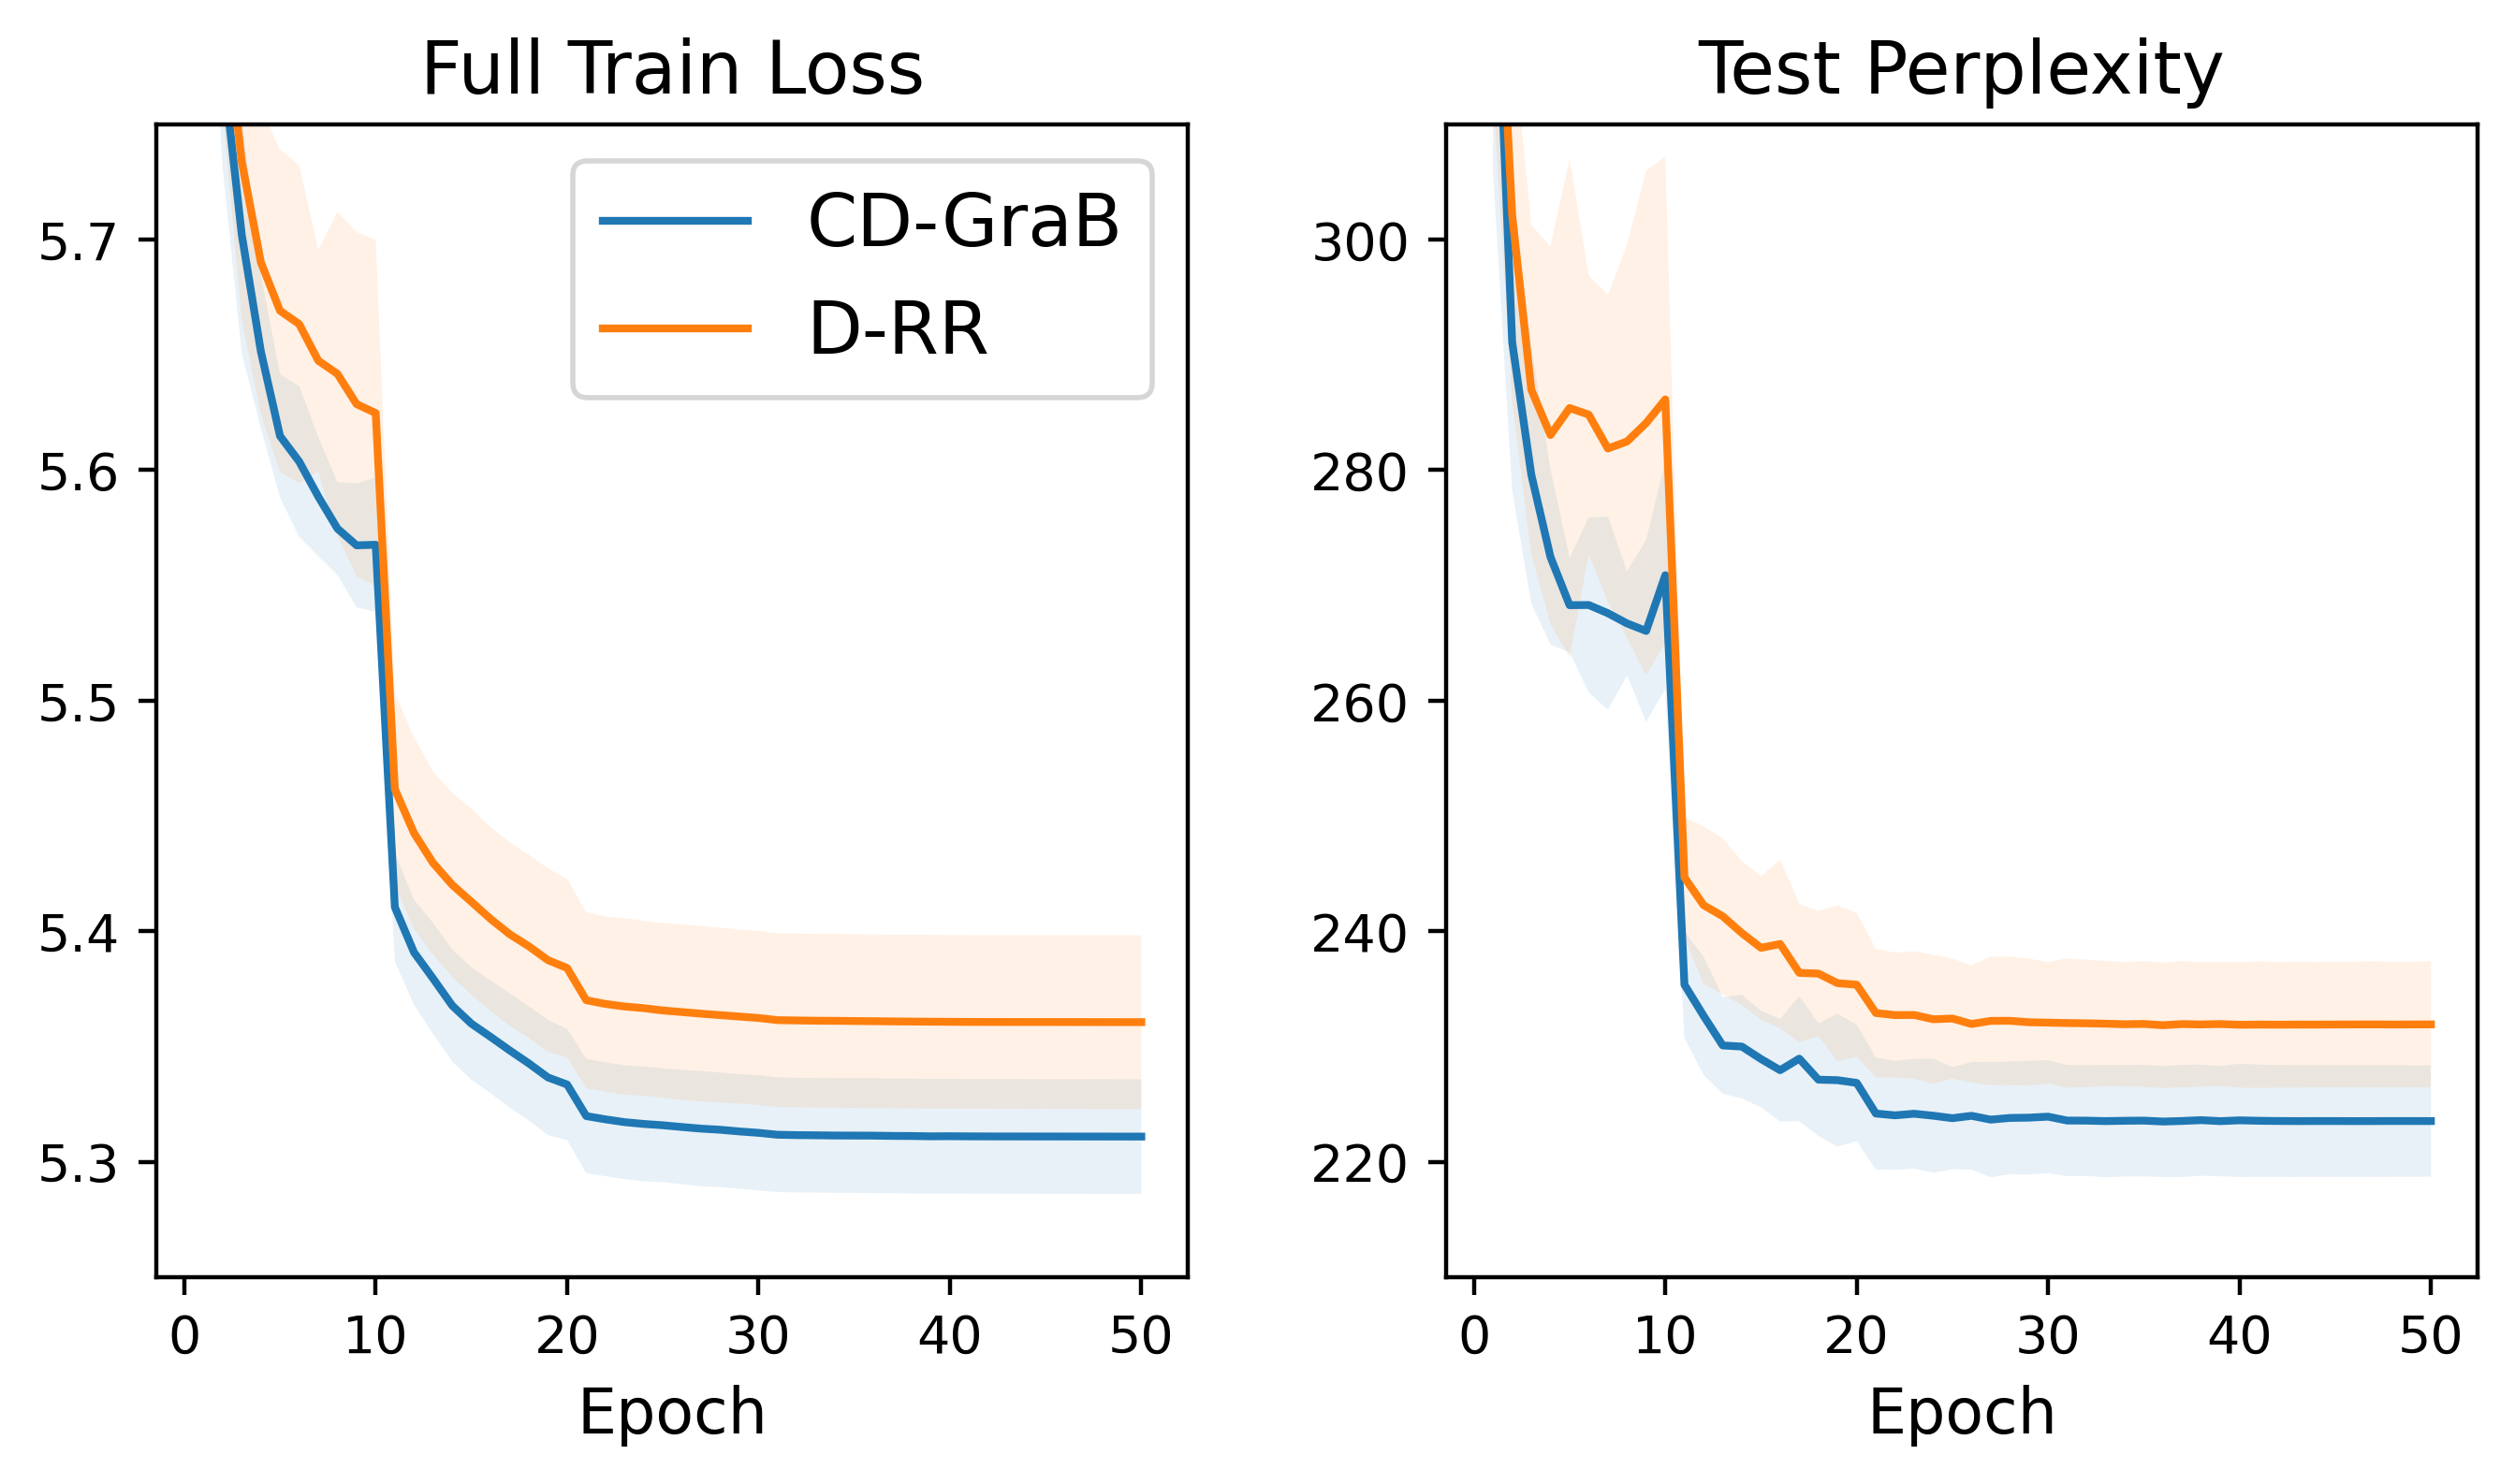

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=400, gridspec_kw=dict(wspace=0.25), sharex=True)

plot_res(axes[0], "CD-GraB", "CD-GraB", "train", 'loss')
plot_res(axes[0], "D-RR", "D-RR", "train", 'loss')

axes[0].legend(fontsize=14, loc='upper right')
axes[0].set_title('Full Train Loss', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylim(5.25, 5.75)

plot_res(axes[1], "CD-GraB", "CD-GraB", "test", 'ppl')
plot_res(axes[1], "D-RR", "D-RR", "test", 'ppl')

axes[1].set_title('Test Perplexity', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylim(210, 310)
fig.tight_layout()
# fig.savefig(f'..{os.sep}..{os.sep}graph{os.sep}LSTM-epoch.png')

In [5]:
def plot_time(ax, s, label, train_test, loss_ppl, dasheddot=False):
    res = []
    for arr in results[s]:
        res.append(torch.tensor(arr[train_test][loss_ppl]))
    res = torch.vstack(res).numpy()
    time_res = []
    for time_arr in times[s]:
        one_time = []
        for e in range(1, res.shape[1] + 1):
            one_time.append(sum(time_arr[f'epoch-{e}']))
        one_time = torch.tensor(one_time) / 1000
        time_res.append(torch.cumsum(one_time, dim=0))
    time_res = torch.vstack(time_res).numpy()
    time_res = time_res.mean(axis=0)
    mean = res.mean(axis=0)
    std = res.std(axis=0)
    if dasheddot:
        ax.plot(time_res, mean, label=label, linestyle='dashed')
    else:
        ax.plot(time_res, mean, label=label, markersize=5)
    ax.fill_between(
        time_res, (mean - std), (mean + std), alpha=0.1)


/tmp/ipykernel_4177930/752763310.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


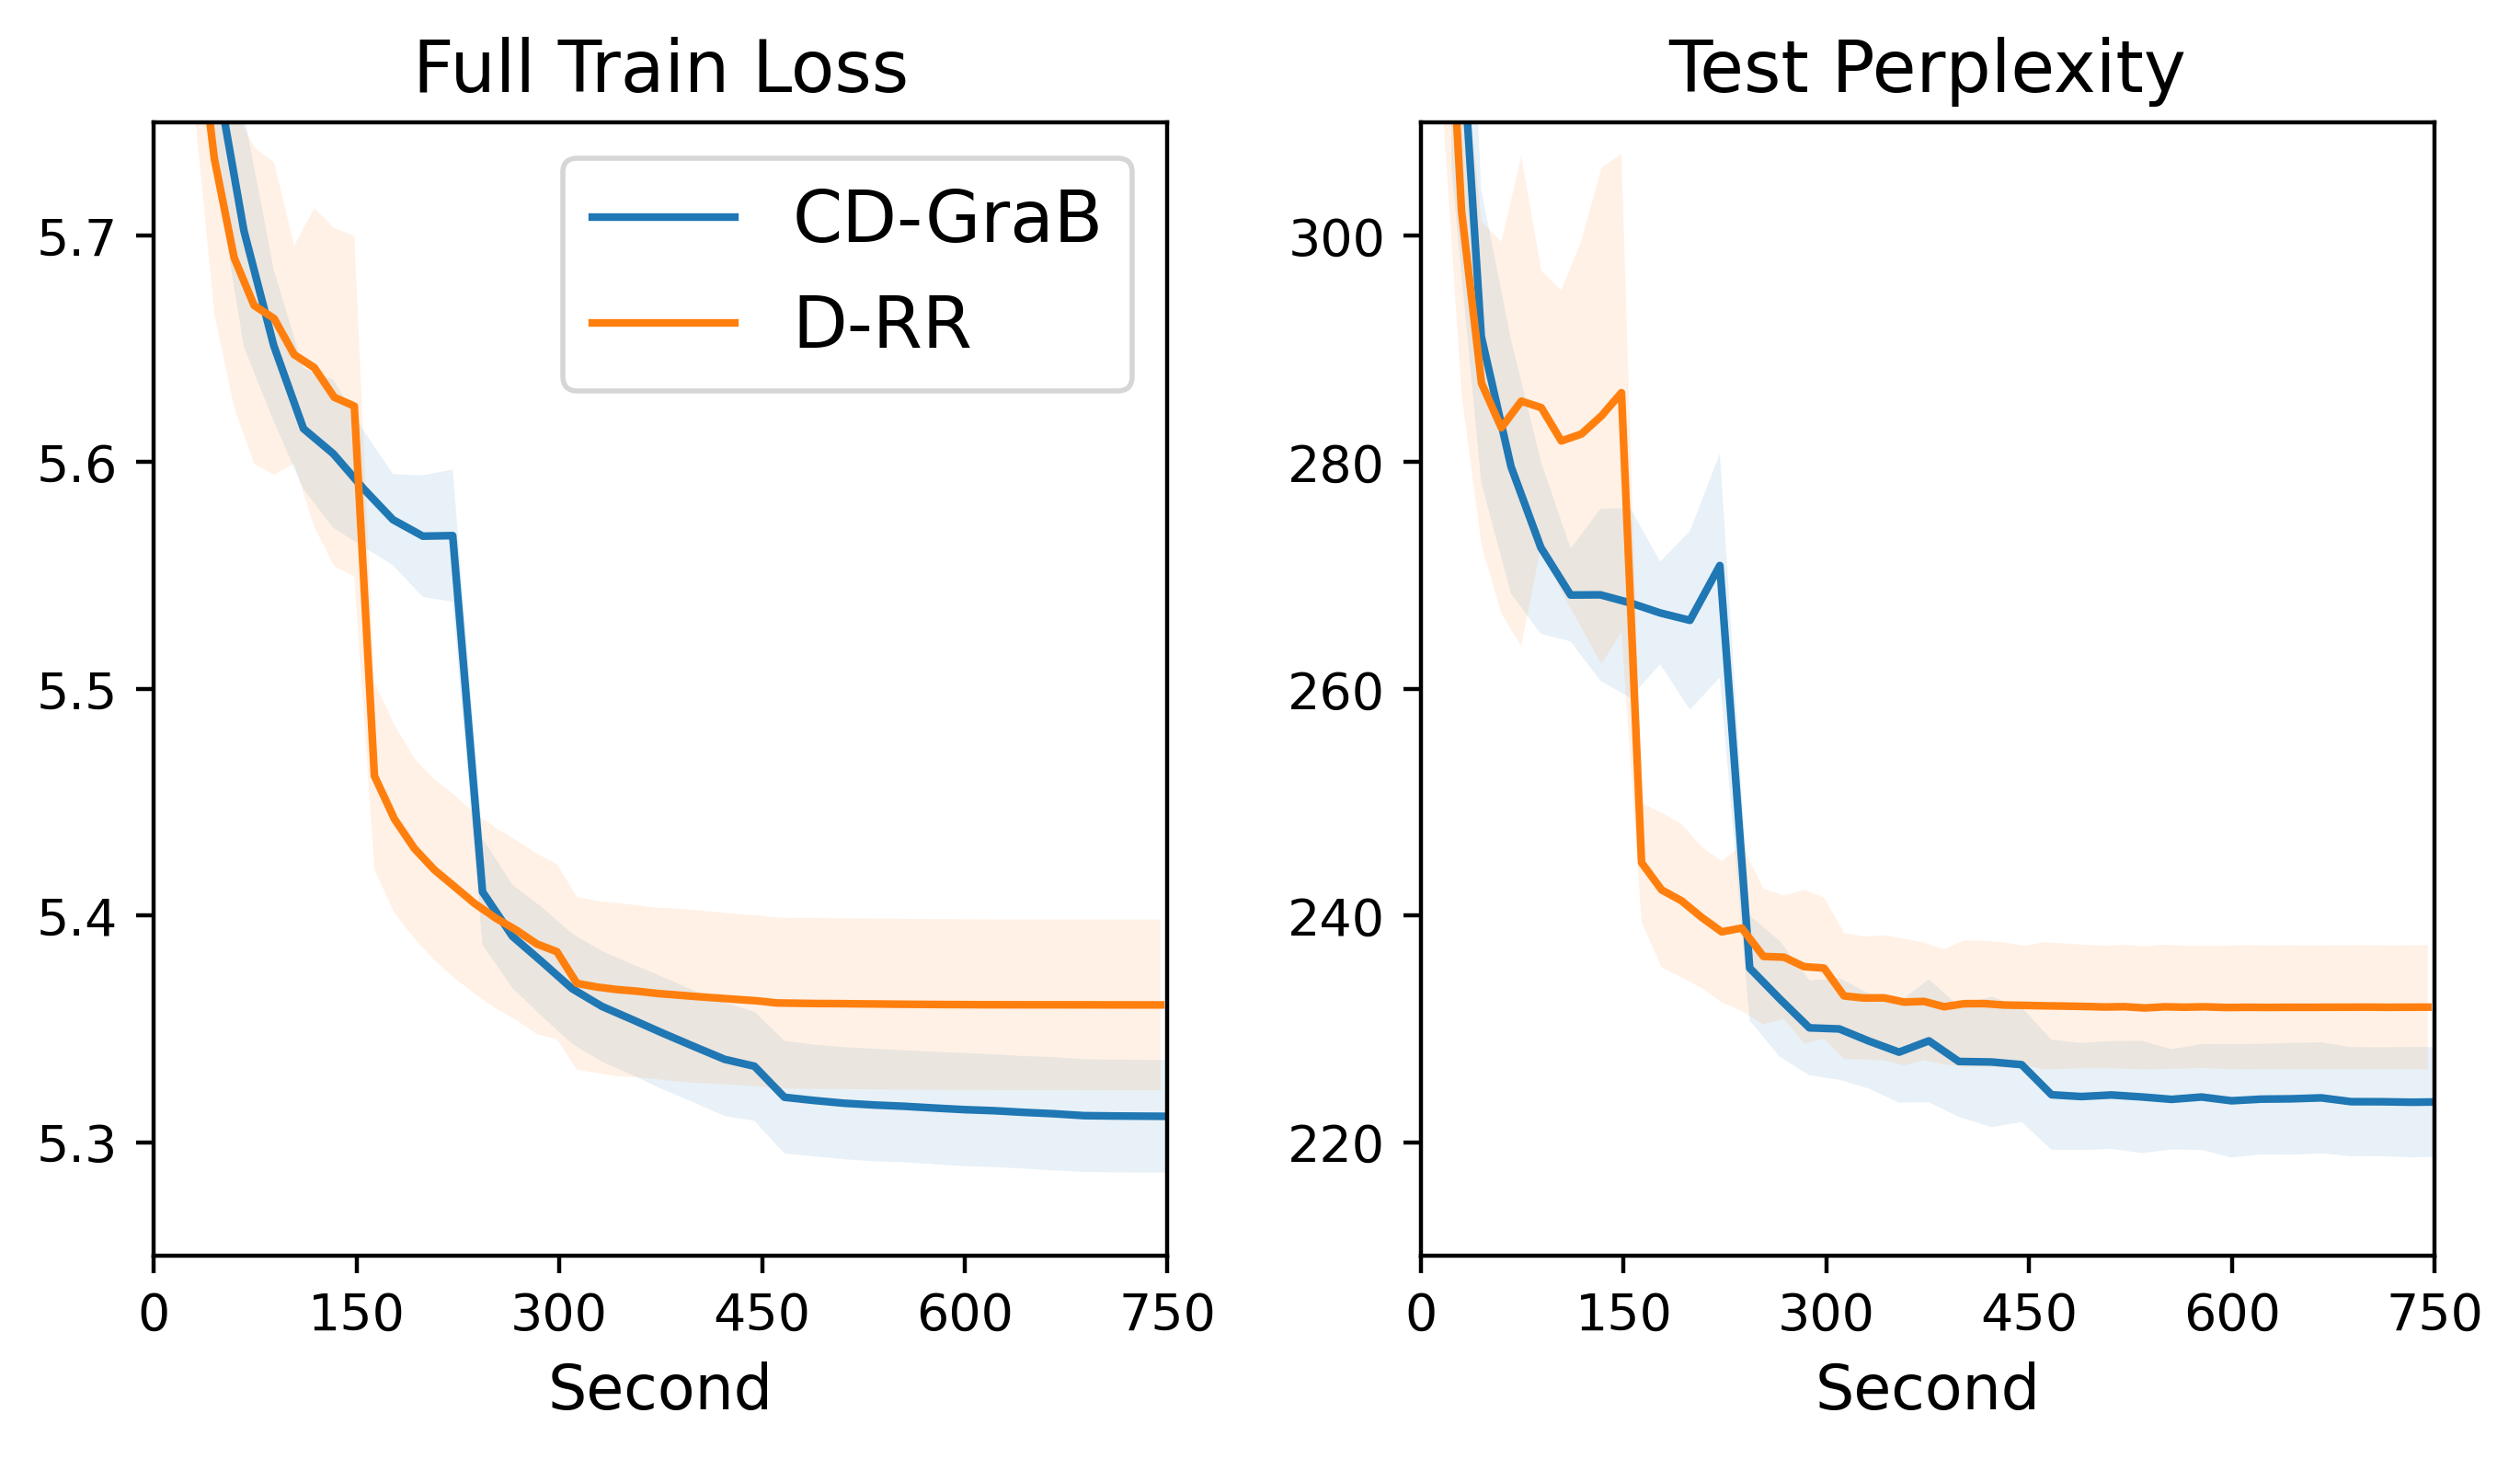

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=400, gridspec_kw=dict(wspace=0.25), sharex=True)

plot_time(axes[0], "CD-GraB", "CD-GraB", "train", 'loss')
plot_time(axes[0], "D-RR", "D-RR", "train", 'loss')

axes[0].legend(fontsize=14, loc='upper right')
axes[0].set_title('Full Train Loss', fontsize=14)
axes[0].set_xlabel('Second', fontsize=12)
axes[0].set_xlim(0, 750)
axes[0].set_ylim(5.25, 5.75)
axes[0].set_xticks([0, 150, 300, 450, 600, 750])

plot_time(axes[1], "CD-GraB", "CD-GraB", "test", 'ppl')
plot_time(axes[1], "D-RR", "D-RR", "test", 'ppl')

axes[1].set_title('Test Perplexity', fontsize=14)
axes[1].set_xlabel('Second', fontsize=12)
axes[1].set_xlim(0, 750)
axes[1].set_ylim(210, 310)
axes[1].set_xticks([0, 150, 300, 450, 600, 750])
fig.tight_layout()
fig.savefig(f'..{os.sep}..{os.sep}graph{os.sep}LSTM-second.png')

In [6]:
time_comp = {s: dict() for s in d_sorts}
epoch = 100
for s in d_sorts:
    for time_arr in times[s]:
        for k, v in time_arr.items():
            if k.startswith('epoch'):
                continue
            if k in time_comp:
                time_comp[s][k].append(sum(v) / (1000))
            else:
                time_comp[s][k] = [sum(v) / (1000)]

for s, time_dict in time_comp.items():
    for k, v in time_dict.items():
        time_comp[s][k] = np.array(v).mean() / epoch


/tmp/ipykernel_1370690/2325806615.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0)


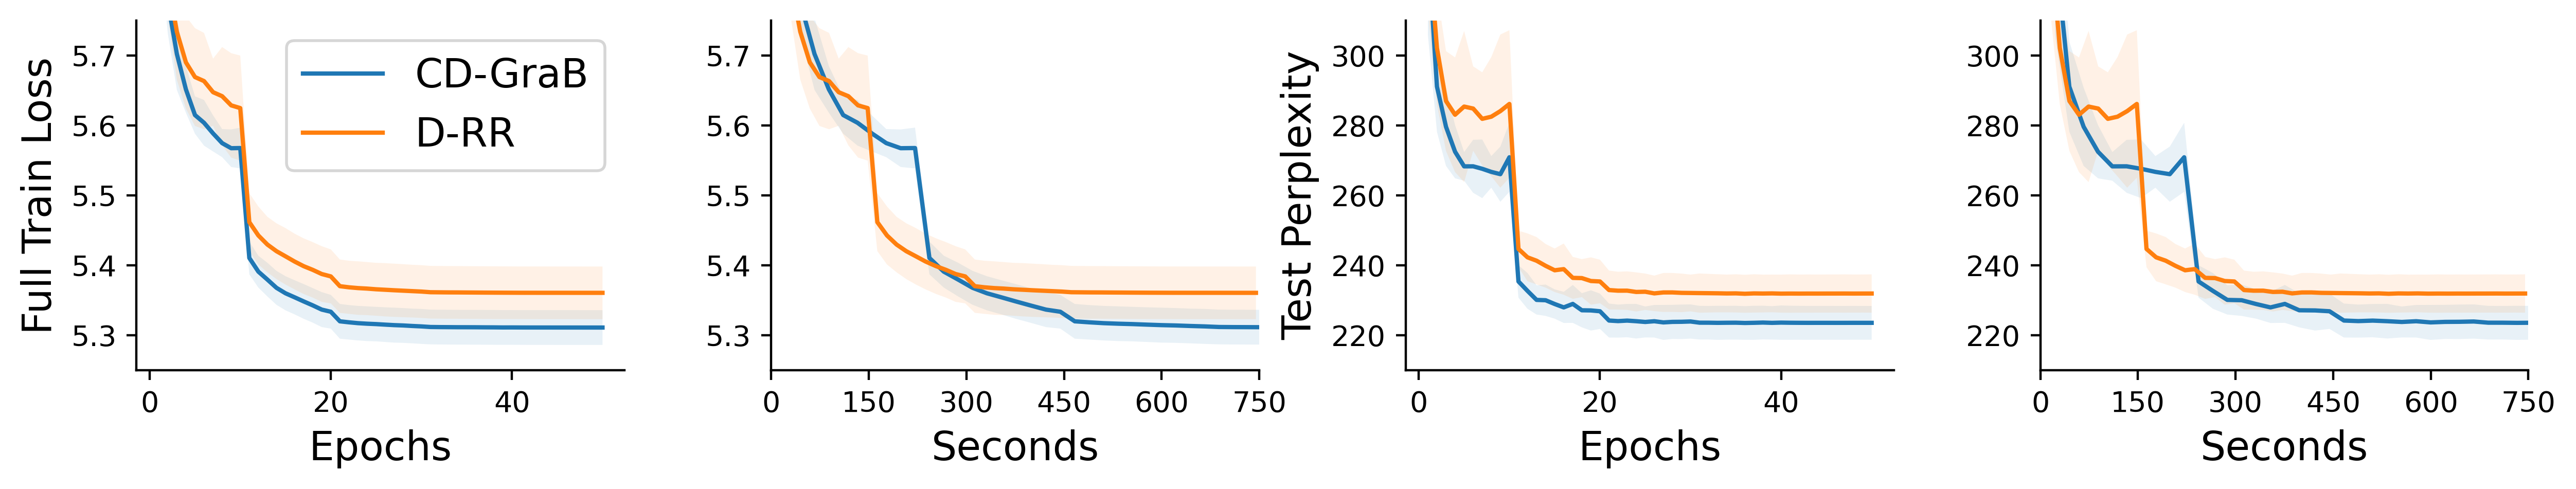

In [41]:
fig, axes = plt.subplots(ncols=4, figsize=(
    15, 2.5), dpi=400, gridspec_kw=dict(wspace=0.3, bottom=0.2))

plot_res(axes[0], "CD-GraB", "CD-GraB", "train", 'loss')
plot_res(axes[0], "D-RR", "D-RR", "train", 'loss')

axes[0].legend(fontsize=14, loc='upper right')
axes[0].set_ylabel('Full Train Loss', fontsize=14)
axes[0].set_xlabel('Epochs', fontsize=14)
axes[0].set_ylim(5.25, 5.75)
axes[0].spines[['right', 'top']].set_visible(False)

plot_time(axes[1], "CD-GraB", "CD-GraB", "train", 'loss')
plot_time(axes[1], "D-RR", "D-RR", "train", 'loss')

axes[1].set_xlabel('Seconds', fontsize=14)
axes[1].set_xlim(0, 750)
axes[1].set_ylim(5.25, 5.75)
axes[1].set_xticks([0, 150, 300, 450, 600, 750])
axes[1].spines[['right', 'top']].set_visible(False)
# axes[1].set_yticklabels([])


plot_res(axes[2], "D-GraB", "D-GraB", "test", 'ppl')
plot_res(axes[2], "D-RR", "D-RR", "test", 'ppl')

axes[2].set_ylabel('Test Perplexity', fontsize=14)
axes[2].set_xlabel('Epochs', fontsize=14)
axes[2].set_ylim(210, 310)
axes[2].spines[['right', 'top']].set_visible(False)

plot_time(axes[3], "CD-GraB", "CD-GraB", "test", 'ppl')
plot_time(axes[3], "D-RR", "D-RR", "test", 'ppl')

axes[3].set_xlabel('Seconds', fontsize=14)
axes[3].set_xlim(0, 750)
axes[3].set_ylim(210, 310)
axes[3].set_xticks([0, 150, 300, 450, 600, 750])
axes[3].spines[['right', 'top']].set_visible(False)
# axes[3].set_yticklabels([])
for ax in axes:
    ax.tick_params(axis='both', which='minor', labelsize=14)
fig.tight_layout(pad=0)
fig.savefig(f'..{os.sep}..{os.sep}graph{os.sep}LSTM-together.png')
fig.savefig(f'..{os.sep}..{os.sep}graph{os.sep}LSTM-together.pdf', format="pdf", bbox_inches="tight")

In [34]:
cuda_max_d_pb = {'communication': (16.50634765625, 2.8372018337249756), 'dataset': (0.0029296875, 0.0), 'forward-backward': (
    36.29437255859375, 0.2947864234447479), 'sorter': (4.35595703125, 0), 'optimizer': (4.13134765625, 0.0), }


In [37]:
cuda_max_d_rr = {'dataset': (0.04158685728907585, 2.8899428844451904), 
                'forward-backward': (36.29437255859375, 0.2947864234447479), 
                'communication': (0.0, 0.0), 
                'optimizer': (4.13134765625, 0.0), 
                 'sorter': (0.02880859375, 0)}


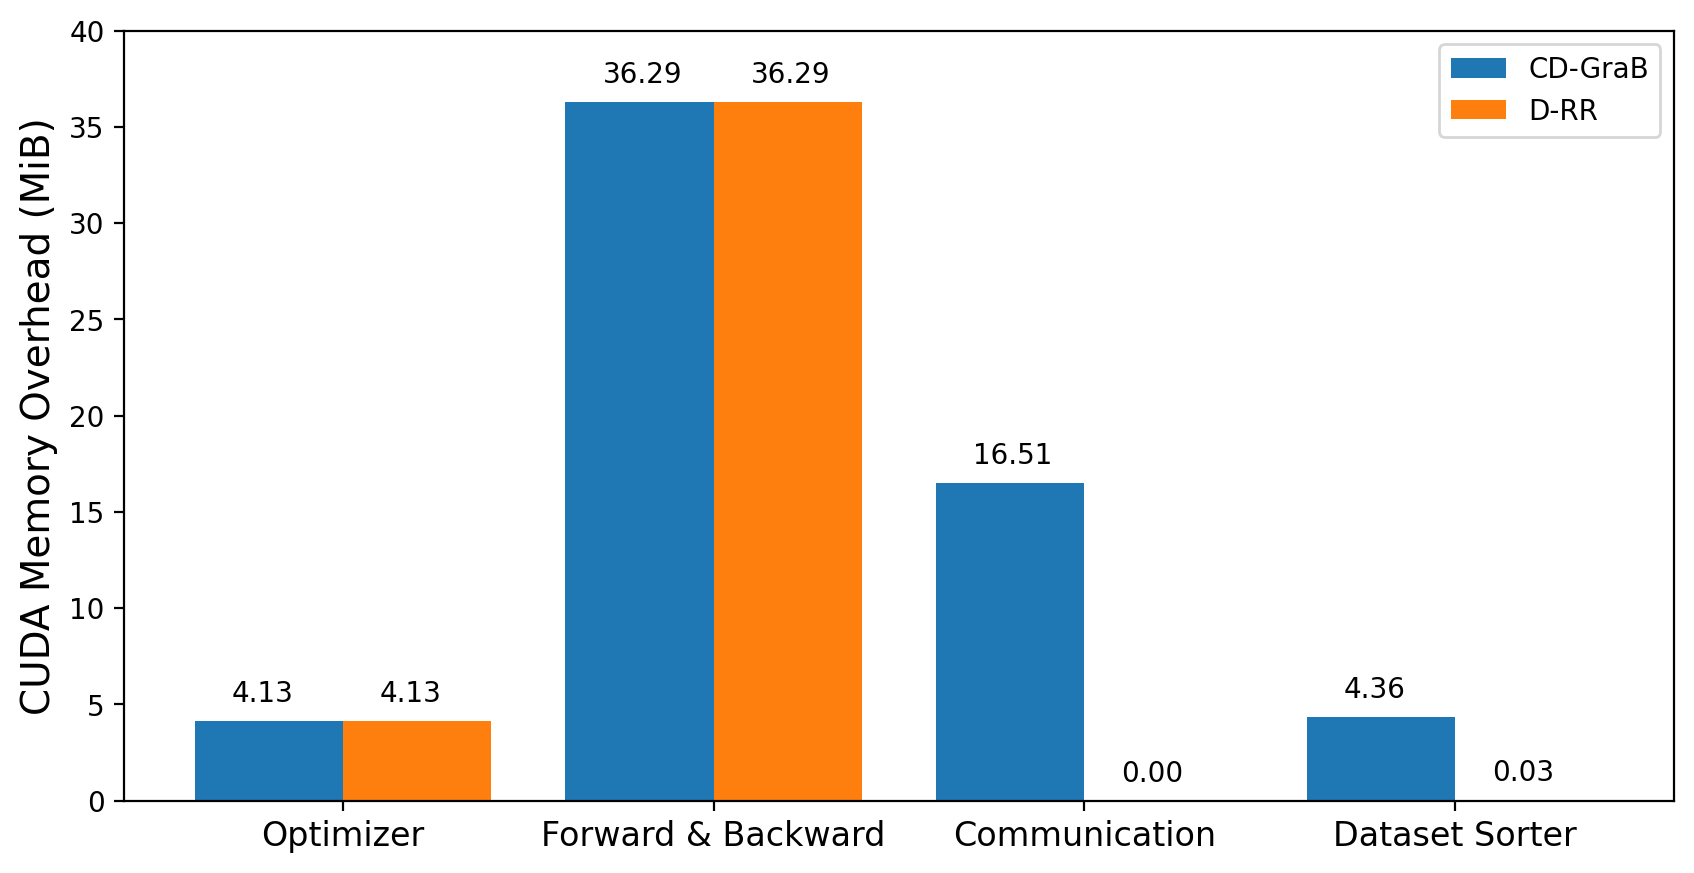

In [63]:
keys = ['optimizer', 'forward-backward', 'communication', 'sorter']
d_rr_memory = [cuda_max_d_rr[k][0] for k in keys]
d_rr_memory_std = [cuda_max_d_rr[k][1] for k in keys]
d_pb_memory = [cuda_max_d_pb[k][0] for k in keys]
d_pb_memory_std = [cuda_max_d_pb[k][1] for k in keys]


plt.figure(dpi=200, figsize=(10, 5))
plt.bar(torch.arange(-0.2, 3.8, 1), d_pb_memory, width=.4, label='CD-GraB', capsize=10)
# yerr=d_pb_memory_std,

for i in range(4):
    plt.text(torch.arange(-.3, 3.8, 1)[i], d_pb_memory[i] + 1, f"{d_pb_memory[i]:.2f}")


plt.bar(torch.arange(0.2, 4.2, 1), d_rr_memory, width=.4, label='D-RR', capsize=10)

# yerr=d_rr_memory_std,
for i in range(4):
    plt.text(torch.arange(0.1, 4.2, 1)[i], d_rr_memory[i] + 1, f"{d_rr_memory[i]:.2f}")

plt.ylabel('CUDA Memory Overhead (MiB)', fontsize=14)
plt.xticks(torch.arange(4), ['Optimizer', 'Forward & Backward', 'Communication', 'Dataset Sorter'], fontsize=12)
plt.legend()
# plt.yscale('log')
plt.ylim(0, 40)
plt.savefig('../../graph/LSTM-mem.png')
plt.savefig(f'../../graph/LSTM-mem.pdf', format="pdf", bbox_inches="tight")